In [1]:
import glob
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [3]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [5]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [6]:
n_rep = 48  # replica number

output_names = [
    "gs_d91r",
    "fs_d91r",
    "d91r_05_31",
    "d91r_06_00",
    "remd_d91r_06_00_23_34423",
    "remd_d91r_06_00_19_42383",
    "remd_d91r_06_00_21_33547",
    "remd_d91r_06_00_25_30869",
]
output_dirs = ["gs_p2.5", "fs_p2.5", "05_31", "06_00", "rerun_0", "rerun_1", "rerun_2", "rerun_3"]
work_dir = "/project/dinner/scguo/kaiB/remd/d91r_iso"

In [7]:
heads = [
    "gs_p2.5_gs_p2.5",
    "fs_p2.5_fs_p2.5",
    "05_31_05_31",
    "06_00_06_00",
    "rerun_0_rerun_0",
    "rerun_1_rerun_1",
    "rerun_2_rerun_2",
    "rerun_3_rerun_3",
]

In [8]:
def load_cvs():
    fs_qtots, f_rmsds, p_rmsds, r_rmsds = [], [], [], []
    q_gs_all, q_gs, q_fs_all, q_fs, q_core = [], [], [], [], []
    
    for d, head in zip(output_dirs, heads):
        fs_qtots.extend(np.load(f"{work_dir}/{d}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
        f_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
        p_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
        r_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))

        q_gs_all.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_gs_all.pkl", allow_pickle=True))
        q_gs.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_gs.pkl", allow_pickle=True))
        q_fs_all.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_fs_all.pkl", allow_pickle=True))
        q_fs.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_fs.pkl", allow_pickle=True))
        q_core.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_core.pkl", allow_pickle=True))

    fs_qtots = np.asarray([traj[:, start_frame:end_frame:skip] for traj in fs_qtots])
    f_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in f_rmsds])
    r_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in r_rmsds])
    p_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in p_rmsds])

    q_gs_all = np.asarray([traj[start_frame:end_frame:skip] for traj in q_gs_all])
    q_fs_all = np.asarray([traj[start_frame:end_frame:skip] for traj in q_fs_all])
    q_gs = np.asarray([traj[start_frame:end_frame:skip] for traj in q_gs])
    q_fs = np.asarray([traj[start_frame:end_frame:skip] for traj in q_fs])
    q_core = np.asarray([traj[start_frame:end_frame:skip] for traj in q_core])

    return fs_qtots, f_rmsds, p_rmsds, r_rmsds, q_gs_all, q_gs, q_fs_all, q_fs, q_core

In [9]:
def load_omegas():
    omegas = []
    for d, n in zip(output_dirs, output_names):
        for i in np.arange(n_rep):
            j = str(i).zfill(2)
            omegas.append(
                np.load(f"{work_dir}/{d}/outputs/{n}.run.{j}_Omega.npy")[start_frame:end_frame:skip]
            )
    return np.array(omegas)

In [10]:
start_frame = 10000  # skip first _ frames
end_frame = 42000
skip = 1  #

fs_qtots, f_rmsds, p_rmsds, r_rmsds, q_gs_all, q_gs, q_fs_all, q_fs, q_core = load_cvs()
omegas = load_omegas()

In [11]:
fs_qtots.shape

(384, 8, 32000)

In [12]:
weights = np.load(f"../../dga/new_87/data/mbar_weights.npy")

In [13]:
c_green = fs_qtots[:, 4] - fs_qtots[:, 5]
c_blue = fs_qtots[:, 6] - fs_qtots[:, 7]
c_orange = fs_qtots[:, 2] - fs_qtots[:, 3]
c_0 = fs_qtots[:, 0] - fs_qtots[:, 1]

In [14]:
n_cis = np.sum((np.abs(omegas[..., 3:]) <= (np.pi / 2.0)).astype(int), axis=-1)
p63_cis = (np.abs(omegas[..., 3]) <= (np.pi / 2.0)).astype(int)
p70_cis = (np.abs(omegas[..., 4]) <= (np.pi / 2.0)).astype(int)
p71_cis = (np.abs(omegas[..., 5]) <= (np.pi / 2.0)).astype(int)
p72_cis = (np.abs(omegas[..., 6]) <= (np.pi / 2.0)).astype(int)

In [15]:
cvs = dict(
    blue=c_blue,
    green=c_green,
    orange=c_orange,
    c0=c_0,
    r_rmsd=r_rmsds,
    q_gs_all=q_gs_all,
    q_fs_all=q_fs_all,
    q_core=q_core,
    n_cis=n_cis,
    q_gs=q_gs,
    q_fs=q_fs,
    q_diff=q_fs - q_gs
)
labels = dict(
    blue=r"$\beta4_{\mathrm{gs}}\longleftrightarrow\alpha3_{\mathrm{fs}}$",
    green=r"$\alpha3_{\mathrm{gs}}\longleftrightarrow\beta4_{\mathrm{fs}}$",
    orange=r"$\alpha2_{\mathrm{gs}}\longleftrightarrow\beta3_{\mathrm{fs}}$",
    c0=r"$\beta3_{\mathrm{gs}}\longleftrightarrow\alpha2_{\mathrm{fs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{fs, C}}-Q_{\mathrm{gs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1.3, 1),
    green=(-1, 1.3),
    orange=(-1, 1.3),
    c0=(-1.3, 1),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

/scratch/local/jobs/18226894/ipykernel_387389/1123097290.py:10: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(dens))
/scratch/local/jobs/18226894/ipykernel_387389/1123097290.py:11: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens) - offset


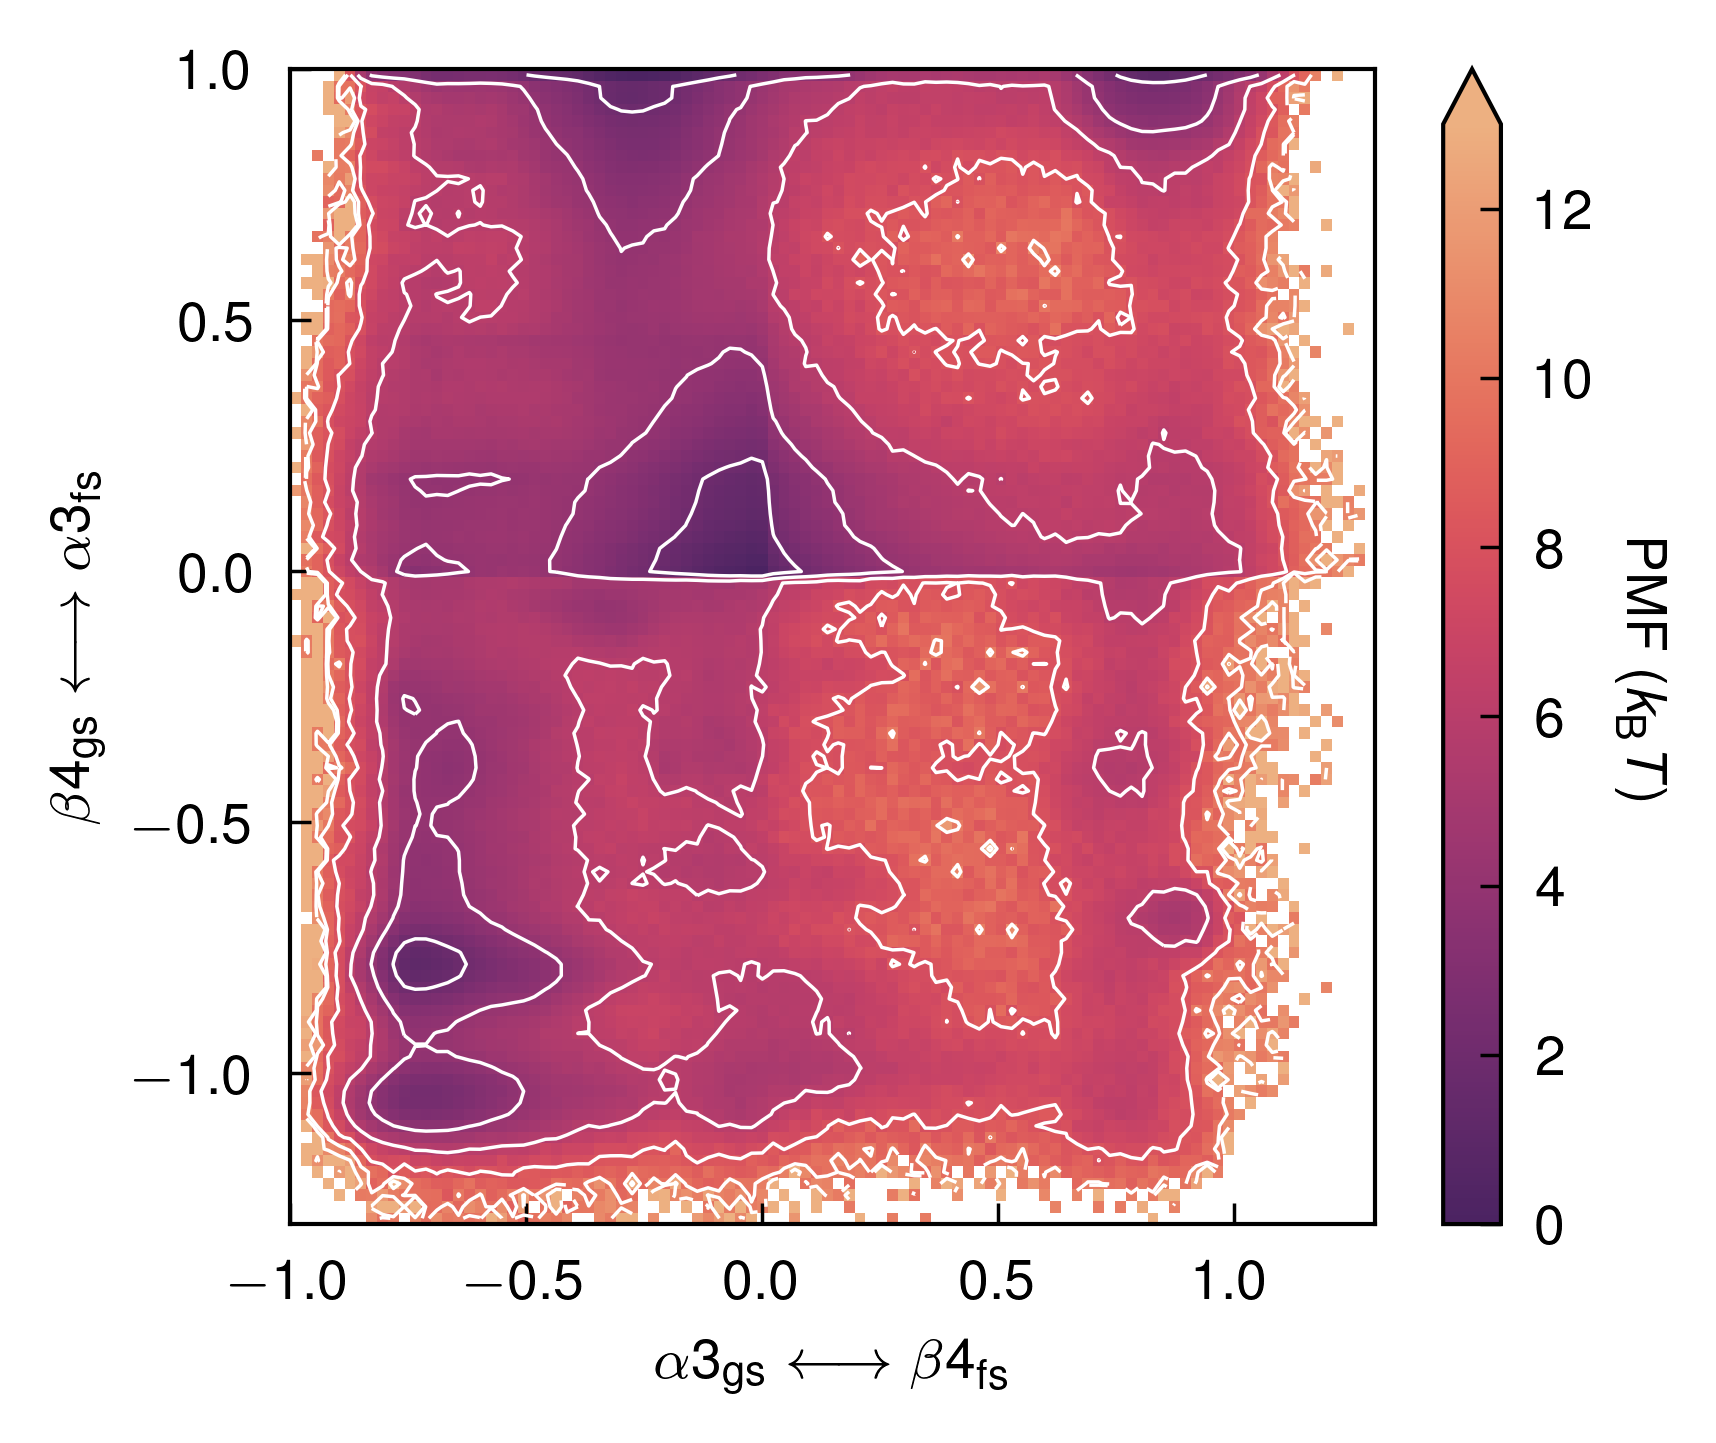

In [17]:
# use mbar weights
cv1, cv2 = "green", "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
dens = extq.projection.density2d(
    cvs[cv1], cvs[cv2], weights, xe, ye
)
offset = np.min(-np.log(dens))
pmf = -np.log(dens) - offset

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=500)
clines = np.arange(0, 13, 2)
pc = ax.pcolormesh(xc, yc, pmf.T, vmax=13, cmap="flare_r", rasterized=True)
ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
ax.set_xlabel(labels[cv1])
ax.set_ylabel(labels[cv2])
cb = plt.colorbar(pc, ax=ax, extend="max")
cb.set_label(r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

/scratch/local/jobs/18226894/ipykernel_387389/2246910161.py:10: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(dens))
/scratch/local/jobs/18226894/ipykernel_387389/2246910161.py:11: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens) - offset


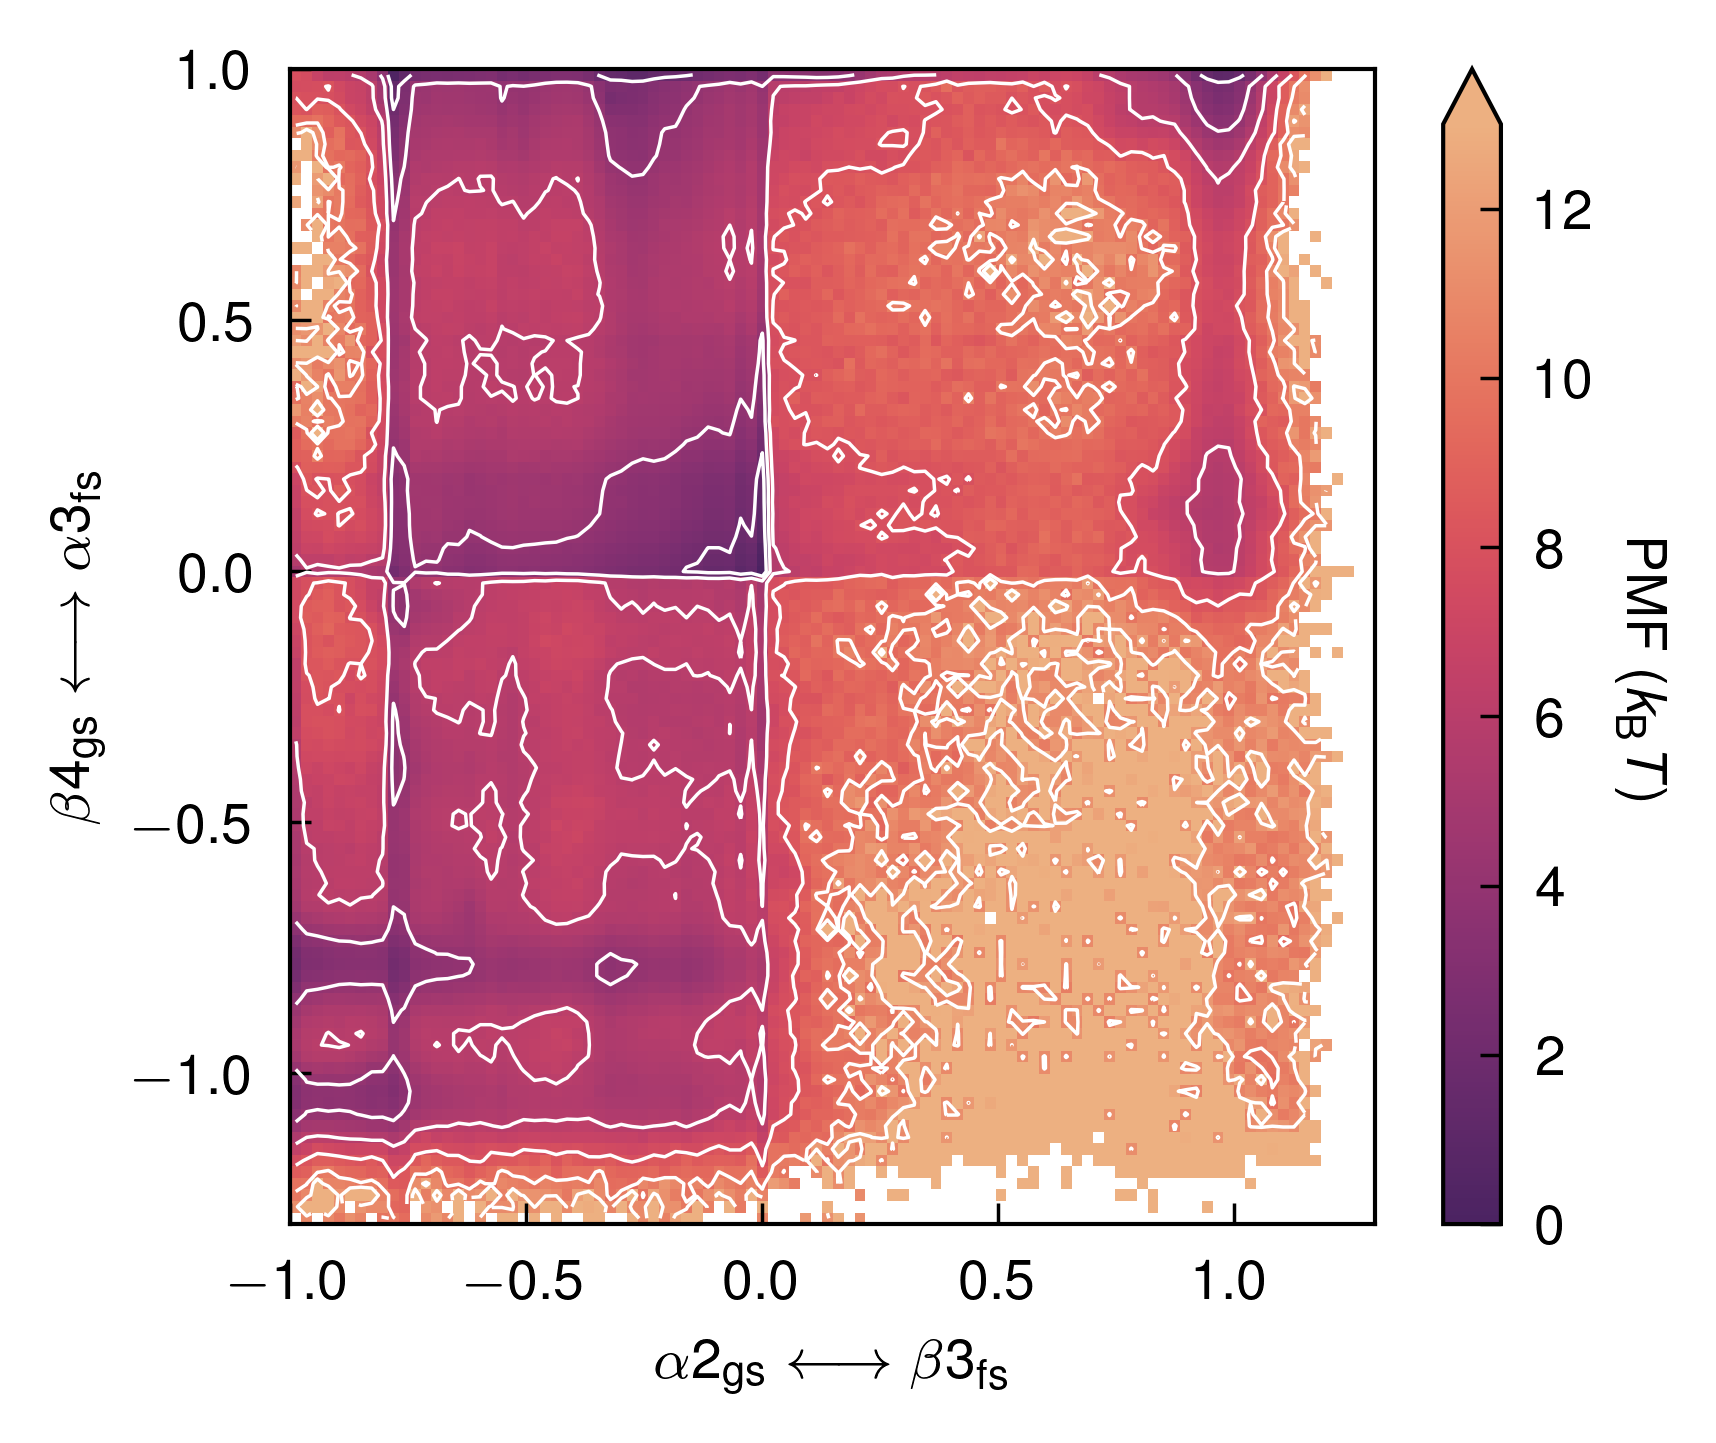

In [18]:
# use mbar weights
cv1, cv2 = "orange", "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
dens = extq.projection.density2d(
    cvs[cv1], cvs[cv2], weights, xe, ye
)
offset = np.min(-np.log(dens))
pmf = -np.log(dens) - offset

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=500)
clines = np.arange(0, 13, 2)
pc = ax.pcolormesh(xc, yc, pmf.T, vmax=13, cmap="flare_r", rasterized=True)
ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
ax.set_xlabel(labels[cv1])
ax.set_ylabel(labels[cv2])
cb = plt.colorbar(pc, ax=ax, extend="max")
cb.set_label(r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

/scratch/local/jobs/18226894/ipykernel_387389/1527124917.py:10: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(dens))
/scratch/local/jobs/18226894/ipykernel_387389/1527124917.py:11: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens) - offset


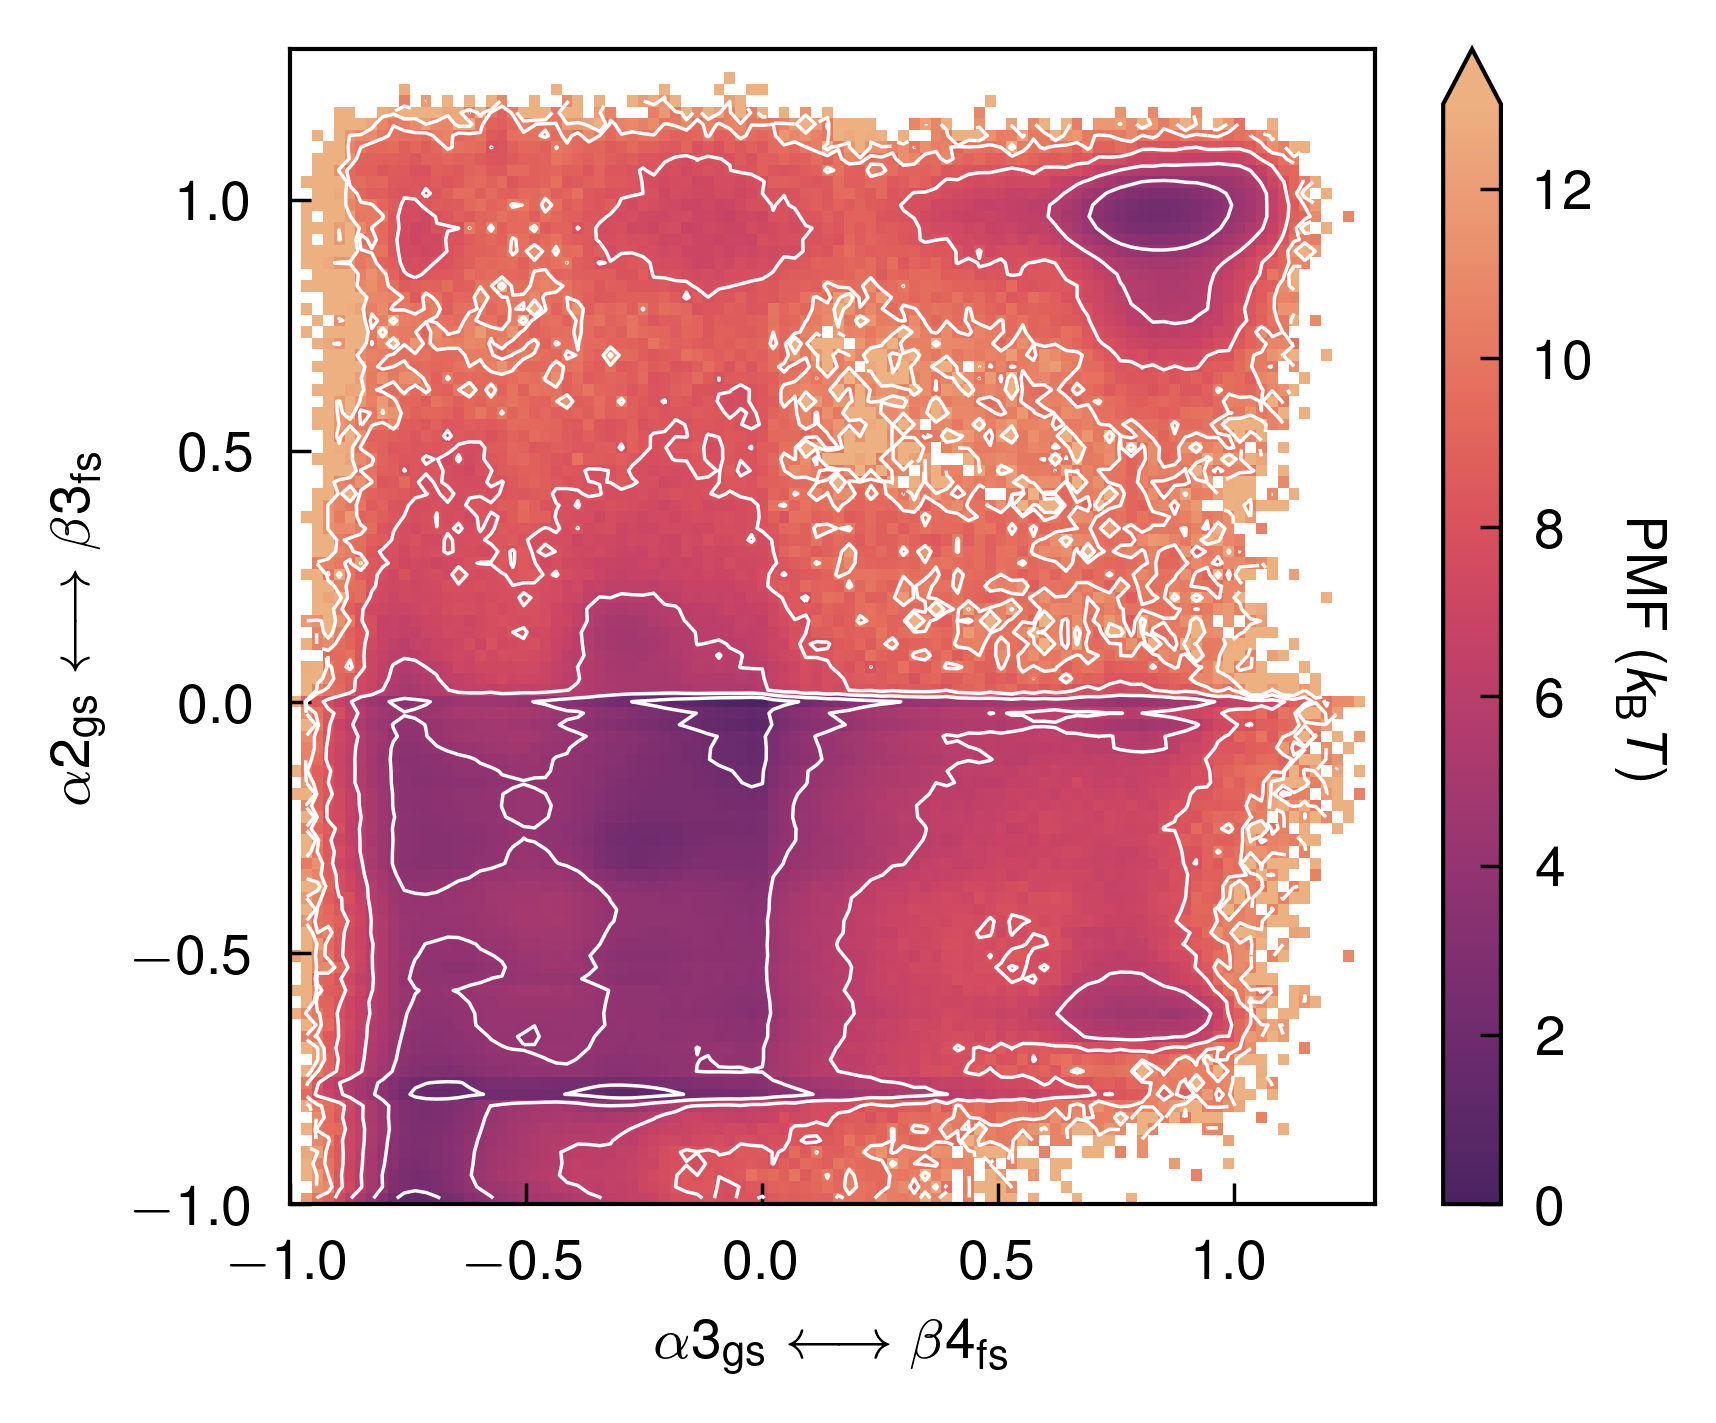

In [19]:
# use mbar weights
cv1, cv2 = "green", "orange"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
dens = extq.projection.density2d(
    cvs[cv1], cvs[cv2], weights, xe, ye
)
offset = np.min(-np.log(dens))
pmf = -np.log(dens) - offset

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=500)
clines = np.arange(0, 13, 2)
pc = ax.pcolormesh(xc, yc, pmf.T, vmax=13, cmap="flare_r", rasterized=True)
ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
ax.set_xlabel(labels[cv1])
ax.set_ylabel(labels[cv2])
cb = plt.colorbar(pc, ax=ax, extend="max")
cb.set_label(r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

/scratch/local/jobs/18226894/ipykernel_387389/1273991609.py:14: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/18226894/ipykernel_387389/1273991609.py:15: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


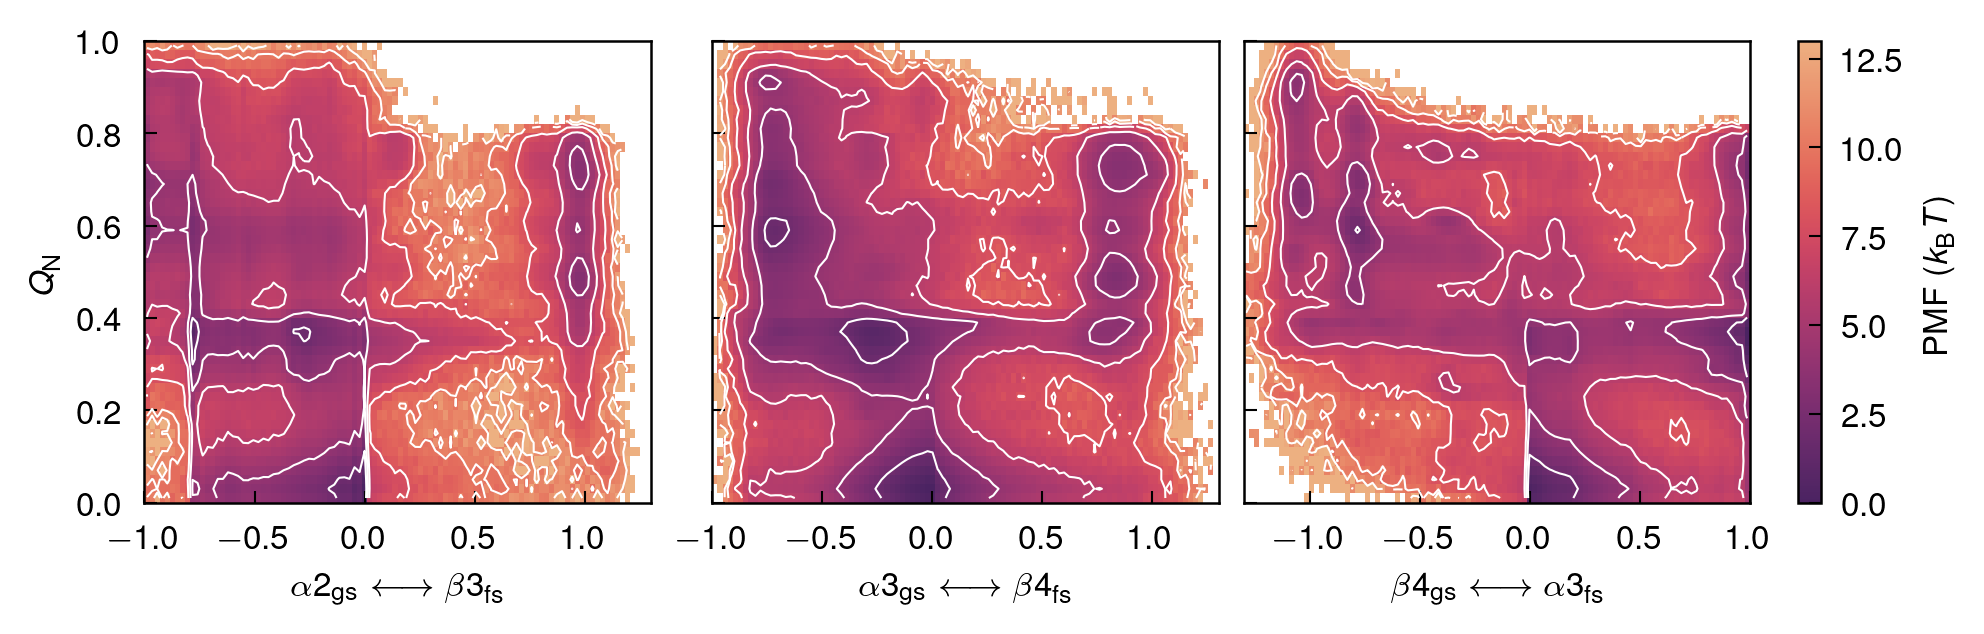

In [20]:
# plot PMFs of different cvs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 2), dpi=300, constrained_layout=True)

ye = np.linspace(0, 1.0, 51)
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 13, 2)

for ax, cv in zip(axes, ["orange", "green", "blue"]):
    xe = np.linspace(*lims[cv], 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density2d(
        cvs[cv], q_core, weights, xe, ye
    )
    offset = np.min(-np.log(hist))
    pmf = -np.log(hist) - offset
    pc = ax.pcolormesh(xc, yc, pmf.T, vmax=13, cmap="flare_r", rasterized=True)
    # ax.plot(np.array(cv)[in_gs][::100], np.array(q_core)[in_gs][::100], ".", alpha=0.1, color="k")
    # ax.plot(np.array(cv)[in_fs][::100], np.array(q_core)[in_fs][::100], ".", alpha=0.1, color="b")
    ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
    ax.set_ylabel(labels["q_core"])
    ax.set_xlabel(labels[cv])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], label=r"PMF ($k_{\mathrm{B}}T$)", location="right")

/scratch/local/jobs/18226894/ipykernel_387389/1273991609.py:14: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/18226894/ipykernel_387389/1273991609.py:15: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


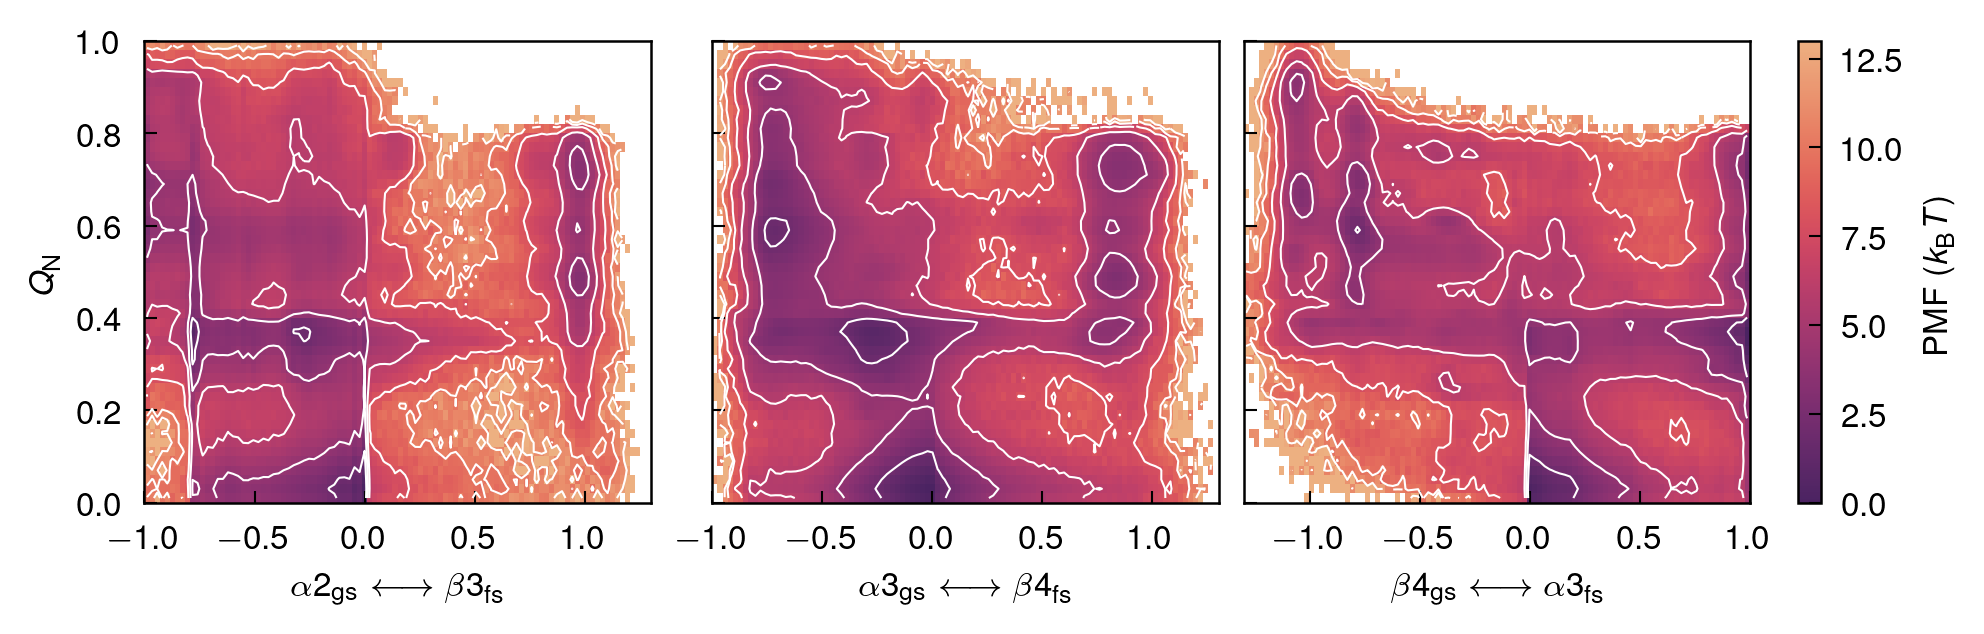

In [21]:
# plot PMFs of different cvs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 2), dpi=300, constrained_layout=True)

ye = np.linspace(0, 1.0, 51)
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 13, 2)

for ax, cv in zip(axes, ["orange", "green", "blue"]):
    xe = np.linspace(*lims[cv], 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density2d(
        cvs[cv], q_core, weights, xe, ye
    )
    offset = np.min(-np.log(hist))
    pmf = -np.log(hist) - offset
    pc = ax.pcolormesh(xc, yc, pmf.T, vmax=13, cmap="flare_r", rasterized=True)
    # ax.plot(np.array(cv)[in_gs][::100], np.array(q_core)[in_gs][::100], ".", alpha=0.1, color="k")
    # ax.plot(np.array(cv)[in_fs][::100], np.array(q_core)[in_fs][::100], ".", alpha=0.1, color="b")
    ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
    ax.set_ylabel(labels["q_core"])
    ax.set_xlabel(labels[cv])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], label=r"PMF ($k_{\mathrm{B}}T$)", location="right")

/scratch/local/jobs/18226894/ipykernel_387389/651210740.py:14: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/18226894/ipykernel_387389/651210740.py:15: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


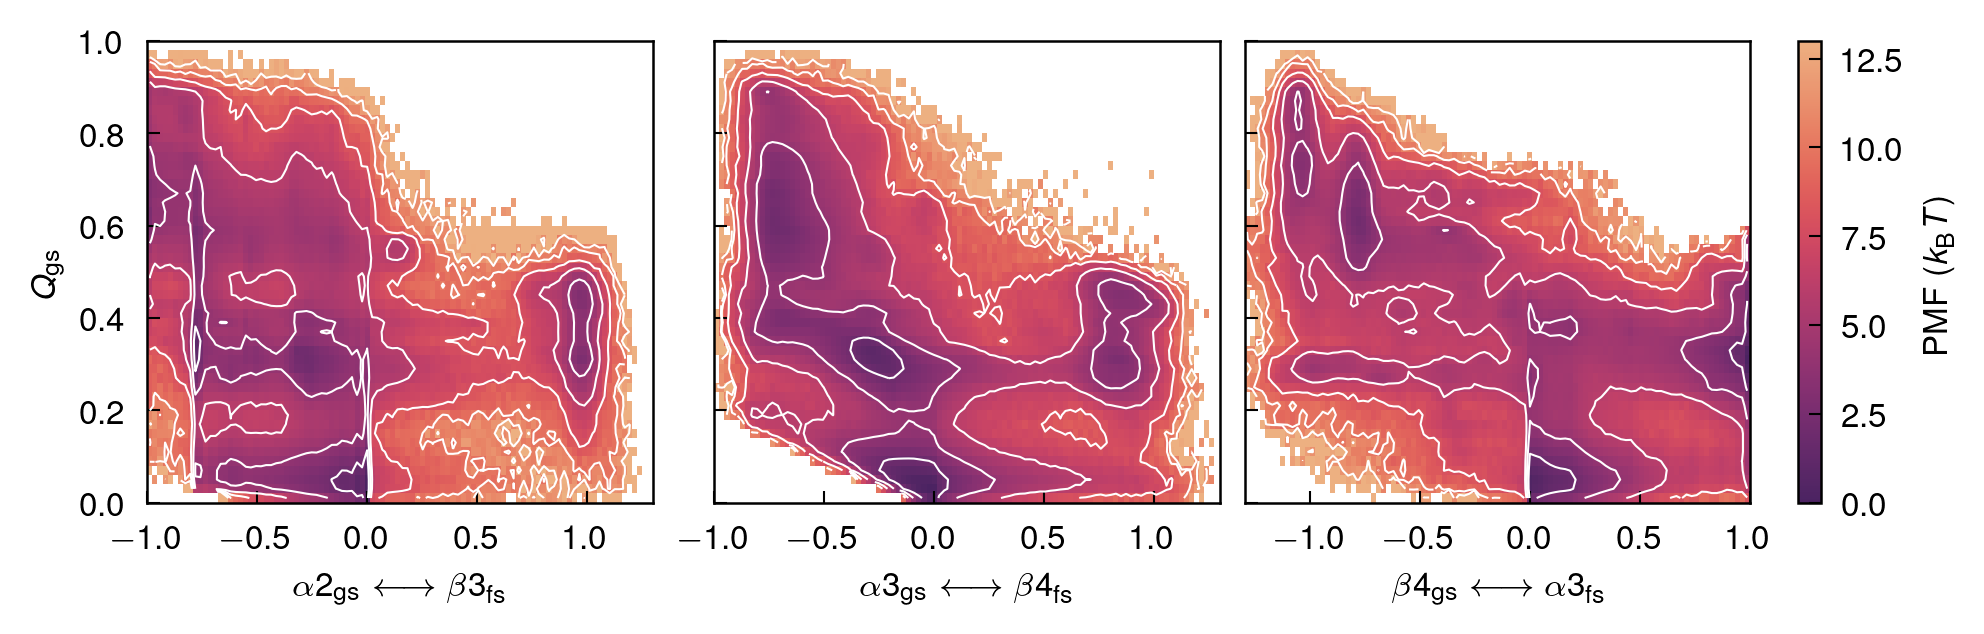

In [22]:
# plot PMFs of different cvs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 2), dpi=300, constrained_layout=True)

ye = np.linspace(0, 1.0, 51)
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 13, 2)

for ax, cv in zip(axes, ["orange", "green", "blue"]):
    xe = np.linspace(*lims[cv], 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density2d(
        cvs[cv], q_gs_all, weights, xe, ye
    )
    offset = np.min(-np.log(hist))
    pmf = -np.log(hist) - offset
    pc = ax.pcolormesh(xc, yc, pmf.T, vmax=13, cmap="flare_r", rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
    ax.set_ylabel(labels["q_gs_all"])
    ax.set_xlabel(labels[cv])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], label=r"PMF ($k_{\mathrm{B}}T$)", location="right")

/scratch/local/jobs/18226894/ipykernel_387389/4200708426.py:14: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/18226894/ipykernel_387389/4200708426.py:15: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


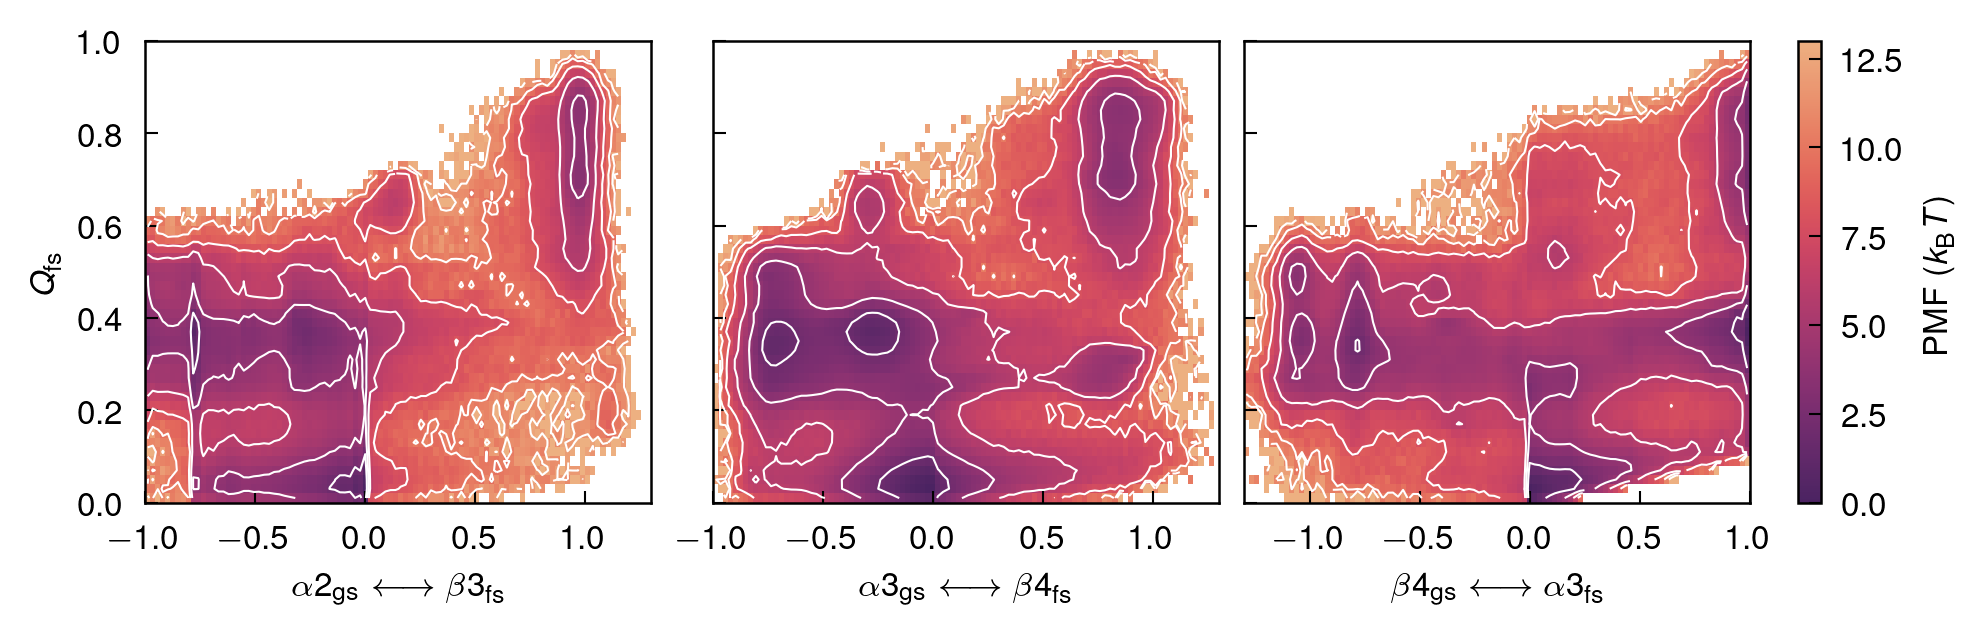

In [23]:
# plot PMFs of different cvs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 2), dpi=300, constrained_layout=True)

ye = np.linspace(0, 1.0, 51)
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 13, 2)

for ax, cv in zip(axes, ["orange", "green", "blue"]):
    xe = np.linspace(*lims[cv], 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density2d(
        cvs[cv], q_fs_all, weights, xe, ye
    )
    offset = np.min(-np.log(hist))
    pmf = -np.log(hist) - offset
    pc = ax.pcolormesh(xc, yc, pmf.T, vmax=13, cmap="flare_r", rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
    ax.set_ylabel(labels["q_fs_all"])
    ax.set_xlabel(labels[cv])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], label=r"PMF ($k_{\mathrm{B}}T$)", location="right")

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


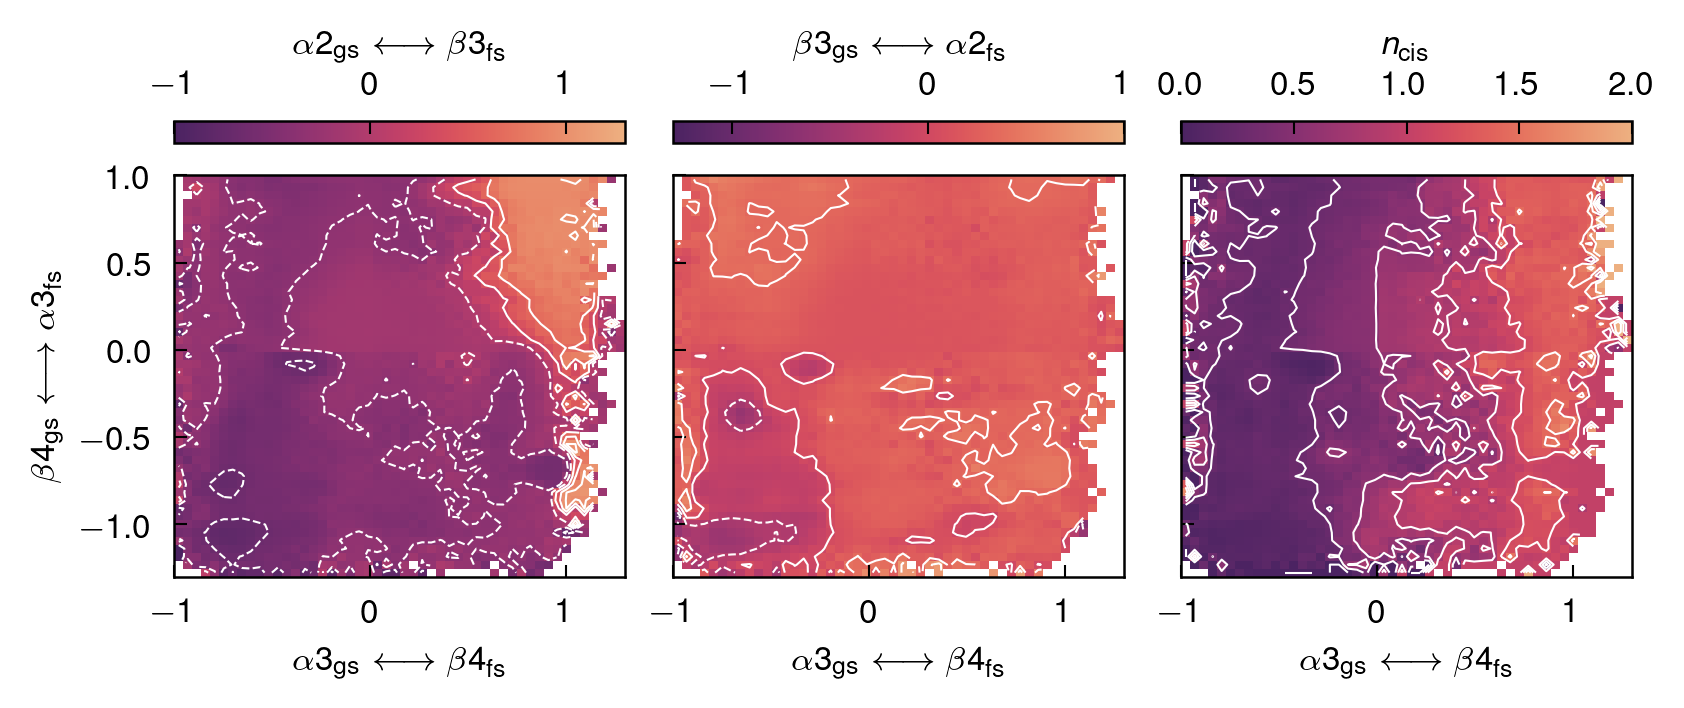

In [24]:
# plot averages of different cvs
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(5.5, 2.25), sharex=True, sharey=True, dpi=300, constrained_layout=True
)

cv1, cv2 = "green", "blue"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2


for ax, cv in zip(axes, ["orange", "c0", "n_cis"]):
    clines = np.linspace(*lims[cv], 8)
    hist = extq.projection.average2d(
        cvs[cv1], cvs[cv2], cvs[cv], weights, xe, ye
    )
    pc = ax.pcolormesh(xc, yc, hist.T, cmap="flare_r", rasterized=True, vmin=lims[cv][0], vmax=lims[cv][1])
    ax.contour(xc, yc, hist.T, colors="white", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
    cb = plt.colorbar(pc, ax=ax, label=labels[cv], location="top")

/scratch/local/jobs/18226894/ipykernel_387389/2610529462.py:8: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/18226894/ipykernel_387389/2610529462.py:9: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


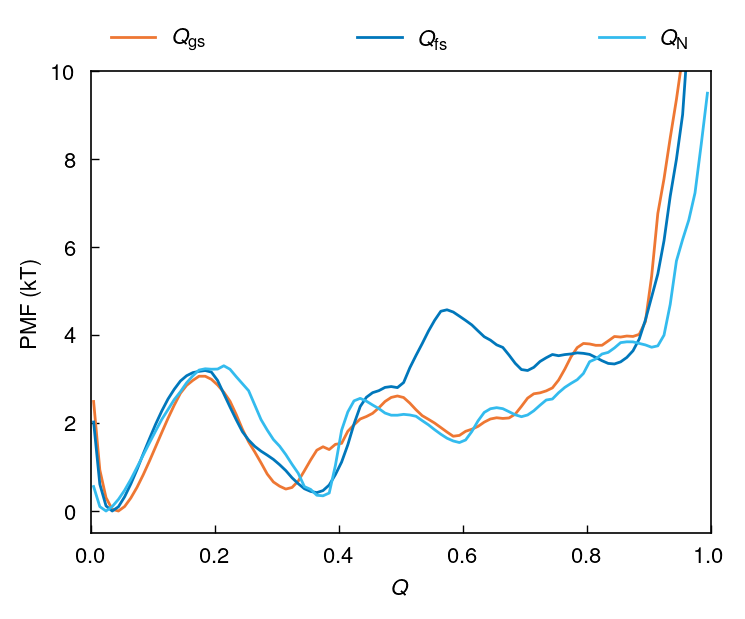

In [25]:
# 1D PMFs
xe = np.linspace(*lims["q_core"], 101)
xc = (xe[:-1] + xe[1:]) / 2

f, ax = plt.subplots(figsize=(4, 3), dpi=200)
for cv in ["q_gs_all", "q_fs_all", "q_core"]:
    hist = extq.projection.density1d(cvs[cv], weights, xe)
    offset = np.min(-np.log(hist))
    pmf = -np.log(hist) - offset
    ax.plot(xc, pmf, label=labels[cv], lw=1)
ax.set_xlim([0, 1.0])
ax.set_ylim([-0.5, 10])
ax.set_xlabel("$Q$")
ax.set_ylabel("PMF (kT)")
pplt.legend(outside="top")